# Cifar-10

Epoch 0: Generator Loss: 0.764483, Discriminator Loss: 1.342712


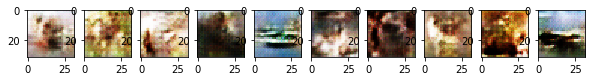

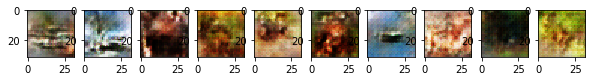

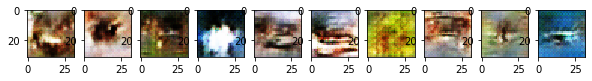

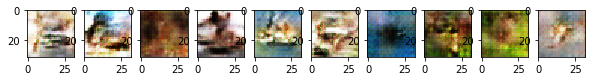

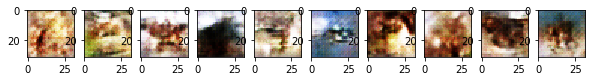

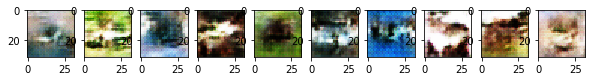

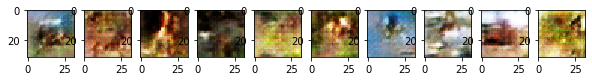

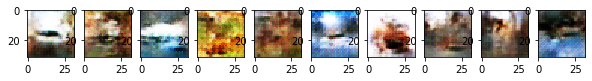

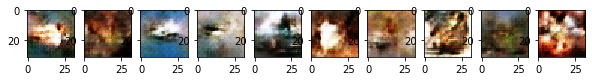

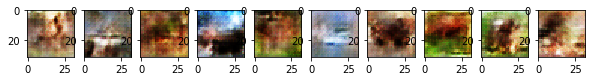

In [18]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

tf.reset_default_graph()

def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='latin1')
    return d
    

def onehot(labels):
    ''' one-hot encoding'''
    n_sample = len(labels)
    n_class = max(labels) + 1
    onehot_labels = np.zeros((n_sample, n_class))
    onehot_labels[np.arange(n_sample), labels] = 1

    return onehot_labels

def convert_images(raw):
    '''
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    '''

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    # Rescale to [-1, 1], the input range of the discriminator
    raw_float = raw_float * 2 - 1
    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


data1 = unpickle('cifar-10-batches-py/data_batch_1')
data2 = unpickle('cifar-10-batches-py/data_batch_2')
data3 = unpickle('cifar-10-batches-py/data_batch_3')
data4 = unpickle('cifar-10-batches-py/data_batch_4')
data5 = unpickle('cifar-10-batches-py/data_batch_5')

X_train = np.concatenate((data1['data'], data2['data'], data3['data'], data4['data'], data5['data']), axis=0) 
X_train = convert_images(X_train)

test = unpickle('cifar-10-batches-py/test_batch')
X_test = test['data'] 
X_test = convert_images(X_test)


# Training Params
training_epochs = 5
num_steps = 10
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
#image_dim = 3072 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points


# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=8 * 8 * 128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 8, 8, 128)
        x = tf.reshape(x, shape=[-1, 8, 8, 128])
        # Deconvolution, image shape: (batch, 16, 16, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Deconvolution, image shape: (batch, 32, 32, 3)
        x = tf.layers.conv2d_transpose(x, 3, 5, strides=2, padding='same')
        # Apply tanh for better stability - clip values to [-1, 1].
        x = tf.nn.tanh(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Flatten
        x = tf.reshape(x, shape=[-1, 8*8*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):#確保先執行gen_update_ops
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
    
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
    
        total_batch = int(X_train.shape[0] / batch_size)
        for i in range(total_batch):
            batch_x = X_train[i*batch_size:(i+1)*batch_size]
            #batch_x = convert_images(batch_x)

            # Discriminator Training
            # Generate noise to feed to the generator
            z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
            _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
            # Generator Training
            # Generate noise to feed to the generator
            z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
            _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
        if epoch % 5 == 0:
            print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (epoch, gl, dl))
    # Testing
    # Generate images from noise, using the generator network.
    n = 10
    canvas = np.empty((32 * n, 32 * n, 3))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, noise_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
        # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
        g = (g + 1.) / 2.
        # Reverse colours for better display
        g = (g*255).astype(np.uint8)
        #images = raw_float.reshape([-1, 3, 32, 32])

                
        f, a = plt.subplots(1, n, figsize=(n, 1))
        for i in range(n):
            a[i].imshow(g[i])
        plt.show()
        

In [23]:
t=tf.ones([32])
t          

<tf.Tensor 'ones_4:0' shape=(32,) dtype=float32>